##### Grading Feedback Cell

# IST 718: Big Data Analytics

- Professor: Willard Williamson <wewillia@syr.edu>
- Faculty Assistant: Yash Pasar <yspasar@syr.edu>
## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers from your classmates.  Short code snippets are allowed from the internet.  Code from the class text books or class provided code can be copied in its entirety.__
- There could be tests in some cells (i.e., `assert` and `np.testing.` statements). These tests (if present) are used to grade your answers. **However, the professor and FAs could use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before submitting your work, remember to check for run time errors with the following procedure:
`Kernel`$\rightarrow$`Restart and Run All`.  All runtime errors will result in a minimum penalty of half off.
- Data Bricks is the official class runtime environment so you should test your code on Data Bricks before submission.  If there is a runtime problem in the grading environment, we will try your code on Data Bricks before making a final grading decision.
- All plots shall include a title, and axis labels.
- Grading feedback cells are there for graders to provide feedback to students.  Don't change or remove grading feedback cells.
- Don't add or remove files from your git repo.
- Do not change file names in your repo.  This also means don't change the title of the ipython notebook.
- __Only use spark, spark machine learning, spark data frames, RDD's, and map reduce to solve all problems unless instructed otherwise.__

In [3]:
# read only cell

import os

# get the databricks runtime version
db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
def get_training_filename(data_file_name):    
    # if the databricks env var exists
    if db_env != None:
        # build the full path file name assuming data brick env
        full_path_name = "/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

In [4]:
# import statements here
# create spark and sparkcontext objects
from pyspark.sql import SparkSession
from pyspark.sql import Row
import numpy as np
import pandas as pd
from pyspark.sql.functions import isnan, isnull, when, count, col
from pyspark.sql import functions as fn
import matplotlib.pyplot as plt
from pyspark.mllib.stat import Statistics
from pyspark.ml import feature
# Functionality for regression
from pyspark.ml import regression
# Funcionality for classification
from pyspark.ml import classification
# Object for creating sequences of transformations
from pyspark.ml import Pipeline
import seaborn as sns
from pyspark.ml.feature import StandardScaler
from math import exp, log10, fabs, atan, log
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

# Moore's Law
The frequently cited “Moore’s Law” originated with a 1965 article in Electronics magazine that said the number of transistors in a given area would double every year.

### ONLY use spark functions unless the question instructions say otherwise.

## Question 1 Load the Transistor Data (5 pts)
- Read the MooresLaw.txt file into a spark data frame named trans_df using only spark.  The columns should be named as per the header in the txt file.
- Print the first 5 rows of trans_df 
- Print the shape of trans_df (num_rows, num_cols)
- Make sure to use the get_training_filename function above to obtain the file name based on your runtime environment

In [5]:
# your code here
def split_rdd_element(row):
    #if row != row1:
    return row.split("\t")

moores_law_file = get_training_filename('mooresLaw.txt')
trans_df_rdd = sc.textFile(moores_law_file)
row1 = trans_df_rdd.first()
header = trans_df_rdd.first().split("\t")
trans_df = trans_df_rdd.filter(lambda x: x!= row1).map(split_rdd_element).toDF(header) 
print(trans_df.limit(5).show())         ## Printing the 1st 5 rows of trans_df
print("Shape of trans_df is: ",(trans_df.count(), len(trans_df.columns)))        ##Printing the shape of the trans_df

+---------------+------+-----------+---+---+---+---+
|Intel Processor|  Year|Transistors|   |   |   |   |
+---------------+------+-----------+---+---+---+---+
|           4004|1971.9|       2300|   |   |   |   |
|           8008|1972.3|       3500|   |   |   |   |
|           8080|1974.3|       6000|   |   |   |   |
|           8085|1976.3|       6500|   |   |   |   |
|           8086|1978.5|      29000|   |   |   |   |
+---------------+------+-----------+---+---+---+---+

None
Shape of trans_df is:  (74, 7)


##### Grading Feedback Cell

## Question 2 Transistor Data Cleanup (5 pts)
- Drop all columns in trans_df except the Year and Transistors column.
- Drop rows in trans_df that contain NaN vales
- Prove that trans_df does not contain NaN values by showing a single integer sum of the number of Nan values in the dataframe (should equal 0)

In [157]:
# your code here
#from pyspark.sql.functions import isnan, isnull, when, count, col
#from pyspark.sql import functions as fn

trans_df = trans_df.select(trans_df.Year.cast('float'),trans_df.Transistors.cast('long')).na.drop()
rolled_up = trans_df.select(fn.sum(fn.isnan('Year').cast('int')).alias('sum_col1'),fn.sum(fn.isnan('Transistors').cast('int')).alias('sum_col2'))
rolled_up.select(fn.col('sum_col1')+fn.col('sum_col2').alias('Total_NAs')).collect()[0][0]

0

##### Grading Feedback Cell

## Question 3 Transistor Data Exploration (10 pts)


### Question 3a (3 pts) 
Explore the data in trans_df by plotting transistors vs. year with a scatter plot.  You may use packages outside of spark to perform the task in question 3a.

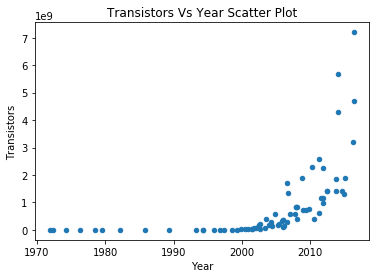

In [7]:
# Your code here
#import matplotlib.pyplot as plt

trans_df.select('Year', 'Transistors').toPandas().plot(x='Year', y='Transistors', kind='scatter');
plt.title("Transistors Vs Year Scatter Plot")
plt.xlabel("Year")
plt.ylabel("Transistors")
display()

##### Grading Feedback Cell

### Question 3b (3 pts)
Compute the correlation between year and number of transistors in the trans_df using spark.  Print the resulting correlation value.  Interpret the correlation in words in the provided markdown cell.

In [8]:
# your code here
#from pyspark.sql import functions as fn
trans_df.select(fn.corr('Year','Transistors')).show()

+-----------------------+
|corr(Year, Transistors)|
+-----------------------+
|     0.5434354144405419|
+-----------------------+



##### Grading Feedback Cell

### Question 3c (4 pts) 
- Interpret the correlation value computed above in the markdown cell below.

Your correlation interpretation here:
The correlation value measure the strength and direction of linear relationship between two set of values. Correlation ranges between -1 and 1, where -1 denotes a strong negative correlation, 1 denotes a strong positive correlation and 0 denotes no relationship. In this case the correlation between Year and Transistors is 0.54, which means that there is a positive relationship between Year and Transistors, i.e. as the year progresses (with increase in year), the Transistors keep on increasing. This correlation value agrees with Moore's Law which talks about how the number of transistors double every year.

##### Grading Feedback Cell

## Question 4 Transform the Data (10 pts)

### Question 4a (5 pts)
- Create a new data frame named trans_df_2 that adds a log transform to the transistors col in trans_df.
- Print the head of trans_df_2
- Print the shape of trans_df_2

In [11]:
# your code here
trans_df_2 = trans_df.select('Year','Transistors',fn.log('Transistors').alias('Log_Transistors'))
print("Head of trans_df_2 is: ",trans_df_2.head())
print("The shape of trans_df_2 is: ",(trans_df_2.count(), len(trans_df_2.columns))) 

Head of trans_df_2 is:  Row(Year=1971.9000244140625, Transistors=2300, Log_Transistors=7.7406644019172415)
The shape of trans_df_2 is:  (74, 3)


##### Grading Feedback Cell

### Question 4b (5 pts)
- Using trans_df_2, create a scatter plot of log transistors vs. year.  You may use packages outside of spark for this task.

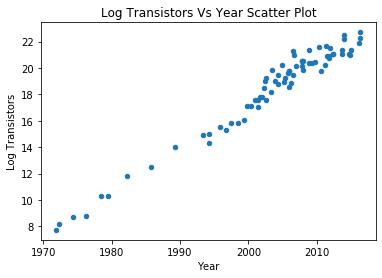

In [154]:
# your code here
trans_df_2.select('Year', 'Log_Transistors').toPandas().plot(x='Year', y='Log_Transistors', kind='scatter');
plt.title("Log Transistors Vs Year Scatter Plot")
plt.xlabel("Year")
plt.ylabel("Log Transistors")
display()

##### Grading Feedback Cell

## Question 5 Fit a Linear Regression Pipeline (10 pts)

### Question 5a ( 2 pts)
- Split trans_df_2 into train and test splits with a 60:40 ratio.  Name the resulting data frames trans_train and trans_test.  Print the shape of of the train and test data frames.

In [33]:
# your code here
trans_train, trans_test = trans_df_2.randomSplit([0.6, 0.4],12343)
print("The shape of train data is: ",(trans_train.count(), len(trans_train.columns))) 
print("The shape of test data is: ",(trans_test.count(), len(trans_test.columns))) 

The shape of train data is:  (44, 3)
The shape of test data is:  (30, 3)


##### Grading Feedback Cell

### Question 5b (6 pts)
- Create a spark pipeline named trans_pipe to perform linear regression
- Fit the pipeline using the transistors as the targets and year as the features.  Name the resulting fitted pipeline fitted_trans_pipe.
- Fit another pipeline using the log transistors column as the targets and year as the features.  Name the resulting fitted pipeline log_fitted_trans_pipe.

In [34]:
# your code here
va = feature.VectorAssembler(inputCols=['Year'], outputCol='features')
lr_trans = regression.LinearRegression(featuresCol='features', labelCol='Transistors')
trans_pipe = Pipeline(stages=[va, lr_trans])
fitted_trans_pipe = trans_pipe.fit(trans_train)

lr_log_trans = regression.LinearRegression(featuresCol='features', labelCol='Log_Transistors')
log_trans_pipe = Pipeline(stages=[va, lr_log_trans])
log_fitted_trans_pipe = log_trans_pipe.fit(trans_train)

##### Grading Feedback Cell

### Question 5c (2 pts)
- Print the linear regression coefficient in the linear regression object in each fitted model
- Print the linear regression Y intercept in the linear regression object in each fitted model

In [37]:
# your code here
print("The Linear Regression Coefficient is: ",fitted_trans_pipe.stages[1].coefficients[0])
print("The Linear Regression Intercept is: ",fitted_trans_pipe.stages[1].intercept)

print("\nThe Linear Regression Coefficient of Log Fitted Model is: ",log_fitted_trans_pipe.stages[1].coefficients[0])
print("The Linear Regression Intercept of Log Fitted Model is: ",log_fitted_trans_pipe.stages[1].intercept)
#log_fitted_trans_pipe

The Linear Regression Coefficient is:  60124191.65527195
The Linear Regression Intercept is:  -119648328638.46603

The Linear Regression Coefficient of Log Fitted Model is:  0.3364984031625316
The Linear Regression Intercept of Log Fitted Model is:  -655.734029134517


##### Grading Feedback Cell

### Question 6 Test the linear regression pipeline (10 pts)

### Question 6a (5 pts)
- Compute mean squared error (MSE) using the transform method on each fitted model.
- Print the resulting MSEs.

In [39]:
# your code here
mse_transistor = fn.mean((fn.col('Transistors') - fn.col('prediction'))**2).alias('mse of predicted Transistors')
mse_log_transistor = fn.mean((fn.col('Log_Transistors') - fn.col('prediction'))**2).alias('mse of predicted LOG Transistors')
fitted_trans_pipe.transform(trans_test).select(mse_transistor).show()
log_fitted_trans_pipe.transform(trans_test).select(mse_log_transistor).show()

+----------------------------+
|mse of predicted Transistors|
+----------------------------+
|        1.364403248741274...|
+----------------------------+

+--------------------------------+
|mse of predicted LOG Transistors|
+--------------------------------+
|             0.39534279946943013|
+--------------------------------+



##### Grading Feedback Cell

### Question 6b (5 pts)
- Using log_fitted_trans_pipe and any needed support code, predict and print the number of transistors for the years 1970.0, 1980.0, 1990.0, 2000.0, and 2010.0

In [40]:
# Your code here
transistor1970 = exp(log_fitted_trans_pipe.stages[1].intercept + (log_fitted_trans_pipe.stages[1].coefficients[0])*1970)
transistor1980 = exp(log_fitted_trans_pipe.stages[1].intercept + (log_fitted_trans_pipe.stages[1].coefficients[0])*1980)
transistor1990 = exp(log_fitted_trans_pipe.stages[1].intercept + (log_fitted_trans_pipe.stages[1].coefficients[0])*1990)
transistor2000 = exp(log_fitted_trans_pipe.stages[1].intercept + (log_fitted_trans_pipe.stages[1].coefficients[0])*2000)
transistor2010 = exp(log_fitted_trans_pipe.stages[1].intercept + (log_fitted_trans_pipe.stages[1].coefficients[0])*2010)
print("Number of Transistors for year 1970: ",transistor1970)
print("Number of Transistors for year 1980: ",transistor1980)
print("Number of Transistors for year 1990: ",transistor1990)
print("Number of Transistors for year 2000: ",transistor2000)
print("Number of Transistors for year 2010: ",transistor2010)

Number of Transistors for year 1970:  1297.020637190146
Number of Transistors for year 1980:  37526.743857063266
Number of Transistors for year 1990:  1085762.6040278818
Number of Transistors for year 2000:  31414407.730012853
Number of Transistors for year 2010:  908914167.2097497


##### Grading Feedback Cell

# Climate Change

## Question 7 Load the global warming data (5 pts)
- Read the globalWarm.txt file into a spark data frame named global_warm_df using only spark.  The columns should be named as per the header in the txt file.
- Print the first 5 rows of global_warm_df 
- Print the shape of global_warm_df (num_rows, num_cols)
- Make sure to use the get_training_filename function above to obtain the file name based on your runtime environment
- A data description follows:
<ul>
<li/>Temp = annual surface temperature measured in 1/100<sup>o</sup> C   over the 1950-1980 mean.  
<li/>Solar = annual mean intensity of sunlight piercing the atmosphere
<li/>CO2 = annual average fraction CO<sub>2</sub> in atmosphere (#molecules/#molecules of dry air) 
<li/>IceShelf = sea ice in 1MM square miles  hypothesized to reflect heat
<li/>Transmission = volcanic MLO transmission data where eruptions release greenhouse gases but also decrease the temperature
</ul>

In [41]:
# your code here
def split_rdd_element(row):
    #if row != row1:
    return row.split("\t")

globalWarm_file = get_training_filename('globalWarm.txt')
global_warm_df_rdd = sc.textFile(globalWarm_file)
row1 = global_warm_df_rdd.first()
header = global_warm_df_rdd.first().split("\t")
global_warm_df = global_warm_df_rdd.filter(lambda x: x!= row1).map(split_rdd_element).toDF(header) 
global_warm_df = global_warm_df.select(global_warm_df.Year.cast('int'),global_warm_df.Temp.cast('int'),global_warm_df.CO2.cast('float'),
                                      global_warm_df.Solar.cast('float'),global_warm_df.Transmission.cast('float'),
                                      global_warm_df.IceShelf.cast('float'))

print(global_warm_df.limit(5).show())         ## Printing the 1st 5 rows of global_warm_df
print("Shape of global_warm_df is: ",(global_warm_df.count(), len(global_warm_df.columns)))        ##Printing the shape of the global_warm_df

+----+----+------+-------+------------+--------+
|Year|Temp|   CO2|  Solar|Transmission|IceShelf|
+----+----+------+-------+------------+--------+
|1979|   8|336.67|1366.43|   0.9284667|     7.2|
|1980|  19|338.57|1366.51|  0.92966664|    7.85|
|1981|  26|339.92|1366.51|  0.92976665|    7.25|
|1982|   4| 341.3|1366.16|   0.8530667|    7.45|
|1983|  25|342.71|1366.18|  0.89771664|    7.52|
+----+----+------+-------+------------+--------+

None
Shape of global_warm_df is:  (32, 6)


##### Grading Feedback Cell

## Question 8 Global Warming Data Exploration (5 pts)
- Create a temperature vs. year scatter plot from global_warm_df
- You may use packages outside of spark for this question

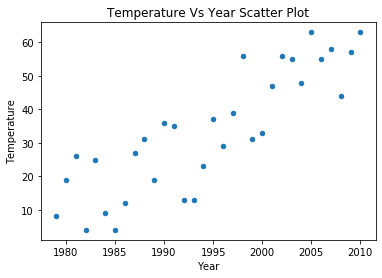

In [155]:
# your code here
# your code here
global_warm_df.select('Year', 'Temp').toPandas().plot(x='Year', y='Temp', kind='scatter');
plt.title("Temperature Vs Year Scatter Plot")
plt.xlabel("Year")
plt.ylabel("Temperature")
display()

##### Grading Feedback Cell

## Question 9 Global Warming Data Exploration (10 pts)


### Question 9a (5 pts)
- Using global_warm_df, create a pair plot of the following variables in a grid:  Temp, CO<sub>2</sub>, Solar, Transmission, and IceShelf.
- You may use packages outside of spark for this question

Text(0.5, 1.05, 'Paiplot of Temp, CO2, Solar, Transmission, IceShelf')

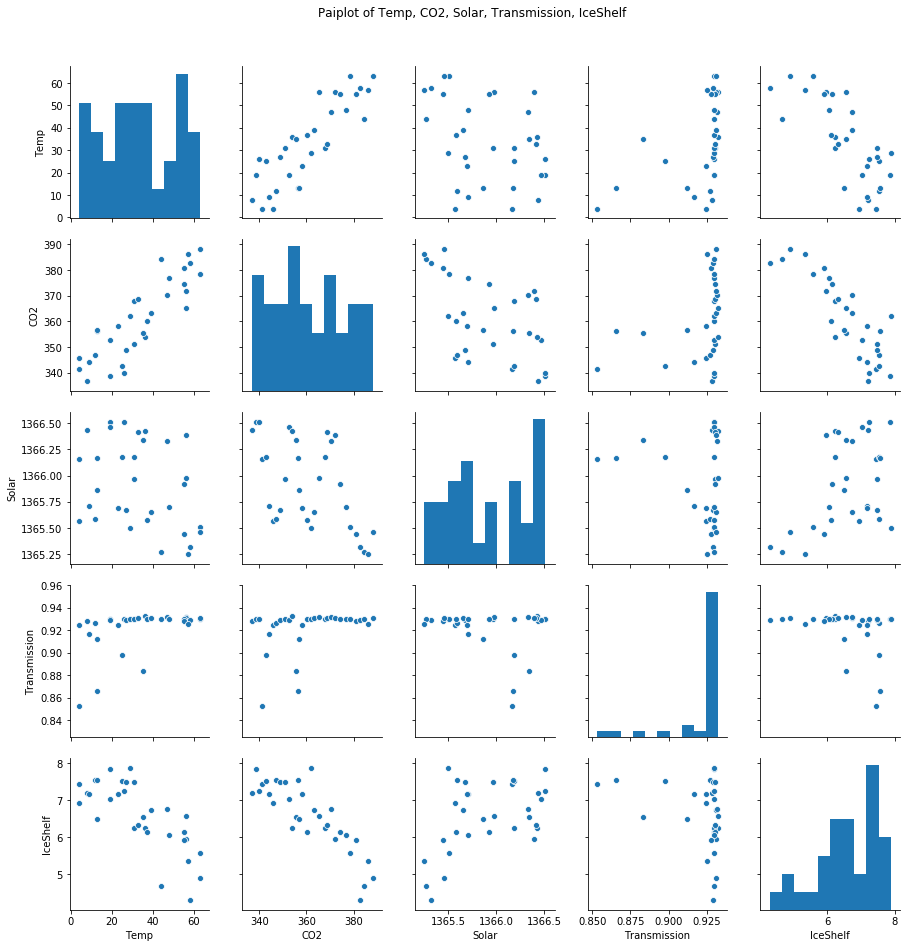

In [44]:
# your code here
ax = sns.pairplot(global_warm_df.toPandas()[['Temp', 'CO2', 'Solar', 'Transmission', 'IceShelf']])
ax.fig.suptitle("Paiplot of Temp, CO2, Solar, Transmission, IceShelf", y=1.05)

##### Grading Feedback Cell

### Question 9b (5 pts)
- Compute a correlation matrix between Temp, CO<sub>2</sub>, Solar, Transmission, and IceShelf using spark.
- Print a labeled correlation matrix.

In [46]:
# your code here
features = global_warm_df.select('Temp','CO2','Solar','Transmission','IceShelf').rdd.map(lambda row: row[0:])
corr_mat = Statistics.corr(features, method="pearson")
corr_mat_lists = [[[k]+l.tolist() for l in list(corr_mat)] for k in ['Temp','CO2','Solar','Transmission','IceShelf']]
corr_mat_lists_2 = [corr_mat_lists[0][0]]+[corr_mat_lists[1][1]]+[corr_mat_lists[2][2]]+[corr_mat_lists[3][3]]+[corr_mat_lists[4][4]]
corr_mat_rdd = sc.parallelize(corr_mat_lists_2)

corr_mat_df = corr_mat_rdd.toDF(['Index','Temp','CO2','Solar','Transmission','IceShelf'])
corr_mat_df.show()

+------------+-------------------+-------------------+--------------------+--------------------+--------------------+
|       Index|               Temp|                CO2|               Solar|        Transmission|            IceShelf|
+------------+-------------------+-------------------+--------------------+--------------------+--------------------+
|        Temp|                1.0| 0.8609275064150844| -0.3403429559548232| 0.43539404481646427| -0.7474254690397607|
|         CO2| 0.8609275064150844|                1.0| -0.5428219485719704|  0.3282277913616061| -0.8469607659494824|
|       Solar|-0.3403429559548232|-0.5428219485719704|                 1.0|-0.20586049601168677|  0.4706903276272281|
|Transmission|0.43539404481646427| 0.3282277913616061|-0.20586049601168677|                 1.0|-0.30248398847116903|
|    IceShelf|-0.7474254690397607|-0.8469607659494824|  0.4706903276272281|-0.30248398847116903|                 1.0|
+------------+-------------------+-------------------+--

##### Grading Feedback Cell

## Question 10 Fit Linear Regression Pipelines (10 pts)

### Question 10a (2 pts)
Split global_warm_df into train and test splits with a 60:40 ratio.  Name the resulting data frames gw_train and gw_test.  Print the shape of of the train and test data frames.   

In [47]:
# your code here
gw_train, gw_test = global_warm_df.randomSplit([0.6, 0.4],12)
print((gw_train.count(), len(gw_train.columns))) 
print((gw_test.count(), len(gw_test.columns))) 

(19, 6)
(13, 6)


##### Grading Feedback Cell

### Question 10b (6 pts)
- Create a spark pipeline named global_warm_pipe to perform linear regression.
- Use the global_warm_df data frame
- Fit a pipeline on the temp column as the target and CO2 as the feature.  Name the resulting fitted pipeline fitted_global_warm_pipe.
- Fit another pipeline on the temp column as the target and all other columns except year as the features.  Name the resulting fitted pipeline fitted_global_warm_pipe_2.

In [48]:
# your code here

va_co2 = feature.VectorAssembler(inputCols=['CO2'], outputCol='features')
lr_global_warm = regression.LinearRegression(featuresCol='features', labelCol='Temp')
global_warm_pipe = Pipeline(stages=[va_co2, lr_global_warm])
fitted_global_warm_pipe = global_warm_pipe.fit(gw_train)

va_all = feature.VectorAssembler(inputCols=['CO2','Solar','Transmission','IceShelf'], outputCol='features_all')
lr_global_warm_all = regression.LinearRegression(featuresCol='features_all', labelCol='Temp')
global_warm_pipe_all = Pipeline(stages=[va_all, lr_global_warm_all])
fitted_global_warm_pipe_2 = global_warm_pipe_all.fit(gw_train)

##### Grading Feedback Cell

### Question 10c (2 pts)
- Print the linear regression coefficient(s) in the linear regression object in each fitted model
- Print the linear regression Y intercept in the linear regression object in each fitted model

In [51]:
# your code here
print("The Linear Regression Coefficient co2 model is: ",fitted_global_warm_pipe.stages[1].coefficients[0])
print("The Linear Regression Intercept co2 model is: ",fitted_global_warm_pipe.stages[1].intercept)

print("\nThe Linear Regression Coefficient of all features Model is: ",fitted_global_warm_pipe_2.stages[1].coefficients)
print("The Linear Regression Intercept of all features Model is: ",fitted_global_warm_pipe_2.stages[1].intercept)

The Linear Regression Coefficient co2 model is:  0.8798406701290213
The Linear Regression Intercept co2 model is:  -281.11507345537973

The Linear Regression Coefficient of all features Model is:  [0.8936794097950107,8.011344551208783,168.03797084940905,-1.827942874965872]
The Linear Regression Intercept of all features Model is:  -11372.662335212566


##### Grading Feedback Cell

### Question 11 Test the linear regression pipeline (10 pts)

### Question 11a (5 pts)
- Compute mean squared error (MSE) using the transform method on each fitted model.
- Print the resulting MSEs.

In [52]:
# your code here
mse_co2 = fn.mean((fn.col('Temp') - fn.col('prediction'))**2).alias('mse of only co2 feature')
mse_all = fn.mean((fn.col('Temp') - fn.col('prediction'))**2).alias('mse of all features')
fitted_global_warm_pipe.transform(gw_test).select(mse_co2).show()
fitted_global_warm_pipe_2.transform(gw_test).select(mse_all).show()

+-----------------------+
|mse of only co2 feature|
+-----------------------+
|     132.88955318312426|
+-----------------------+

+-------------------+
|mse of all features|
+-------------------+
|  97.21417568028954|
+-------------------+



##### Grading Feedback Cell

### Question 11b (5 pts)
- Which of the 2 models have higher performance.  In the cell below, describe why you think the better performing model made the model perform better.

The model which includes all the features is bettter as it has a lower Mean Squared Error. The model with all the features is performing better because by increasing the number of features, the variance of the model is increasing and thereby the fit of the model is improving which is reducing the bias. Hence since the predicted values are closer to the actual values, the MSE is also lower for the model with all the features, which is the better performing model.

### Question 12 Inference (10 pts)

### Question 12a Data Scaling (5 pts)
Add data scaling to fitted_global_warm_pipe_2 above. Name the resulting fitted model fitted_global_warm_pipe_3.  Print the resulting fitted model coefficients such that each coefficient is clearly labeled with it's corresponding feature name.

In [74]:
# your code here

va_pipe2 = feature.VectorAssembler(inputCols=['CO2','Solar','Transmission','IceShelf'], outputCol='features_all')

scaler = StandardScaler(inputCol = 'features_all', outputCol="scaledFeatures",withStd=True, withMean=True)
lr_global_warm_all_scaled = regression.LinearRegression(featuresCol='scaledFeatures', labelCol='Temp')
global_warm_pipe_all_std = Pipeline(stages=[va_pipe2,scaler, lr_global_warm_all_scaled])
fitted_global_warm_pipe_3 = global_warm_pipe_all_std.fit(gw_train)
print("Intercept of the model is: ",fitted_global_warm_pipe_3.stages[2].intercept)
print("Coefficient of CO2 is: ",fitted_global_warm_pipe_3.stages[2].coefficients[0])
print("Coefficient of Solar is: ",fitted_global_warm_pipe_3.stages[2].coefficients[1])
print("Coefficient of Transmission is: ",fitted_global_warm_pipe_3.stages[2].coefficients[2])
print("Coefficient of IceShelf is: ",fitted_global_warm_pipe_3.stages[2].coefficients[3])

Intercept of the model is:  37.421052631578036
Coefficient of CO2 is:  14.400342550378179
Coefficient of Solar is:  3.69445696498837
Coefficient of Transmission is:  3.1268456590488296
Coefficient of IceShelf is:  -1.756452307902348


### Question 12b Inference (5 pts)  
Use the coefficients printed above to gain insights into the global warming problem. Describe your inference conclusions in the cell below.

Coefficient inference conclusions here: 
The insights that we can obtain from these coefficients are that, CO2, Solar and Transmission have a positive impact on temperature, i.e. an increase in CO2 or Solar or Transmission will result in an increase in temperature, whereas on the other hand IceShelf has a negative impact on temperature, i.e. an increase in IceShelf will result in a decrease in temperature.
The coefficient of CO2 is 14.4 which indicates that, 1 standard deviation increase in CO2, keeping all the other variables constant will result in 14.4 units increase in temperature.  When all the variables are 0, the temperature is going to be equal to the intercept. When IceShelf increases by 1 standard deviation the temperature is going to decrease by 1.75 units.

##### Grading Feedback Cell

# Question 13 Extra Credit (10 pts)
This question is optional.  No points will be deducted from your score if you do not attempt this problem.<br>

Starting with the rdd class presented in lecture (maintaining all class method names), implement a my_reduce method in the rdd class.  Your implementation shall maintain rdd class immutability.  Your my_reduce method return type should be consistent with the return type in the real Spark reduce method. Do some research and see what the Spark reduce return type would be.  <br>

Implement a function named times_3 which returns its input multiplied by 3. Implement a function named is_even that returns true if it's input is even, false otherwise.  Implement a my_sum function that returns the sum of its 2 inputs.  <br>

Your overall implementation should not rely on receiving specific data types as inputs.  For example, the plus operator works on more than just ints and floats.

In [190]:
def times_3(el):
    return el*3
    
def is_even(el):
    if el%2 == 0:
        return True
    else:
        return False

def my_sum(a,b):
    return a+b

In [195]:
# your code here
import numpy as np

# define our own simple as possible rdd class
class rdd:
    def __init__(self, arg_array):
        self.local_array = arg_array
    
    # define our own map function
    def my_map(self, fun):
        if len(self.local_array) < 1:
            raise Exception("my_map: len(local_array) < 1")
        
        # create a new numpy array to hold the result
        # remember that rdd's are supposed to be immutable
        mapped = np.empty_like(self.local_array)
        
        # for each element in the local array
        for i, el in enumerate(self.local_array):
            # execute the user defined function on this element
            mapped[i] = fun(self.local_array[i])
        
        # This is the key to how the data is passed.  The return value is another rdd object!
        # The fact that we are returning a new rdd is the key to how chaining works
        # create a new rdd using the array created by applying the user defined function
        return rdd(mapped)
    
    def my_filter(self, fun):
        # create a temporary list to store the filtered results
        transformed = []

        for el in self.local_array:
            if fun(el):
                transformed.append(el)
                
        return rdd(np.array(transformed))
    
    def my_reduce(self,fun):
        if len(self.local_array) < 1:
            raise Exception("my_reduce: len(local_array) < 1")
        total = self.local_array[0]
        for i in range(1,len(self.local_array)):
            total = fun(total,self.local_array[i])
        return total
            
    
    def collect(self):
        return self.local_array

In [196]:
# Simple test code
test_rdd = rdd(np.arange(100))
result = test_rdd.my_map(times_3).my_filter(is_even).my_reduce(my_sum)
print(type(result))
print(result)

# secret grading test code follows


<class 'numpy.int32'>
7350


In [197]:
test_rdd = rdd(['This','is','a','sentence','new','hi'])
result = test_rdd.my_map(times_3).my_reduce(my_sum)
print(type(result))
print(result)

<class 'str'>
ThisThisisisisaaasentencenewnewnehihihi


##### Grading Feedback Cell